# Import Libraries


In [43]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [44]:
import datetime

import missingno as msno

# Data Manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import boxcox

from scipy.optimize import curve_fit

# Time Series Analysis
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose

# Accuracy Metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Data Visualization
from plotly.subplots import make_subplots
from plotly.colors import DEFAULT_PLOTLY_COLORS
import plotly.express as px
import plotly.graph_objects as go

import helper


In [45]:
PLOT_WIDTH, PLOT_HEIGHT = 1000, 500
TITLE_FONT_SIZE = 12
AXIS_FONT_SIZE = 12
helper._init()


Misc Folder located!
Plots Folder located!


# Data Preprocessing


## Load Data


In [46]:
google = helper.fetch_data_from_database(
    table="mobility_stats_google",
    where_column="country_region_code",
    where_value="GR",
    order_by="date",
    date_column="date",
)
covid = helper.fetch_data_from_database(table="covid_data_greece", date_column="date")


Creating connection to the PostgreSQL database...
Opening connection...
Data Fetched
Creating connection to the PostgreSQL database...
Opening connection...
Data Fetched


## Data Cleaning


In [47]:
google.columns = [
    col.removesuffix("_percent_change_from_baseline") for col in google.columns
]


<AxesSubplot:>

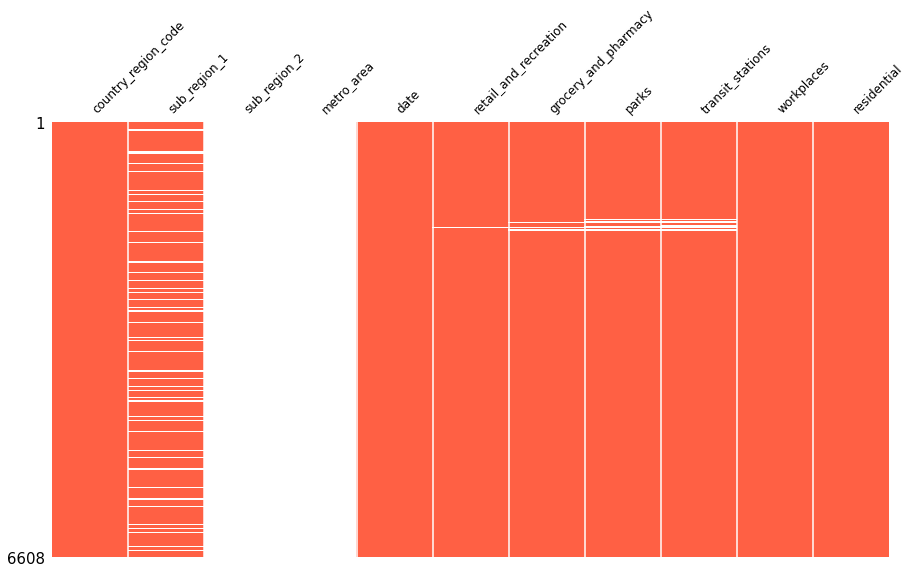

In [48]:
msno.matrix(
    google, figsize=(15, 8), fontsize=12, sparkline=False, color=(1, 0.38, 0.27)
)


In [49]:
google.dtypes


country_region_code              object
sub_region_1                     object
sub_region_2                     object
metro_area                       object
date                     datetime64[ns]
retail_and_recreation           float64
grocery_and_pharmacy            float64
parks                           float64
transit_stations                float64
workplaces                      float64
residential                     float64
dtype: object

In [50]:
# Select columns with numeric values
num_cols = [column for column in google.columns if google[column].dtype == "float64"]
google = helper.preprocess_pipeline(
    df=google,
    numeric_columns=num_cols,
    group_subset=["date", "sub_region_1"],
    threshold=0.8,
)

# Drop samples with missing location info
google = google[~google["sub_region_1"].isna()]


Step 1: Checking for null columns...
--- Found null column: sub_region_2
--- Found null column: metro_area
Step 2: Checking for duplicate entries...
--- No duplicate entries found
Step 3: Dropping samples that have more than 20% missing values
Step 4: Fill remaining null values with forward fill method


In [51]:
regions = google.groupby(by="sub_region_1").groups.keys()

# Population per Region as of 2020 stats
regional_pop = [
    3_828_434,
    623_065,
    620_545,
    2_490_290,
    1_465_554,
    1_280_152,
    508_246,
]

total_pop = sum(regional_pop)
weights = {k: v / total_pop for k, v in zip(regions, regional_pop)}


In [52]:
def weighted_mean(row):
    region = row["sub_region_1"]
    row[num_cols] *= weights.get(region, None)
    return row


In [53]:
google = (
    google.apply(lambda row: weighted_mean(row), axis=1)
    .groupby(by="date", as_index=False)
    .sum(numeric_only=True)
)


In [54]:
# Augment data by adding date-specific columns
google["month"] = google["date"].dt.month
google["year"] = google["date"].dt.year
google["day_name"] = google.date.dt.day_name()


## Check skewness of the features


In [55]:
skewed_cols = [col for col in num_cols[:-2] if np.abs(google[col].skew()) > 0.5]


In [56]:
fig = px.histogram(
    data_frame=google,
    x=skewed_cols[1],
    labels=dict(transit_stations=helper.TITLES[3]),
    title="Data before Box-Cox Transformation",
    nbins=50,
    width=PLOT_WIDTH,
    height=PLOT_HEIGHT,
)

fig.update_layout(
    showlegend=False,
    bargap=0.2,
    font_size=TITLE_FONT_SIZE,
    xaxis=dict(rangeselector_font_size=AXIS_FONT_SIZE),
    yaxis=dict(tickfont_size=AXIS_FONT_SIZE),
)
fig.show()
fig.write_image("../plots/Box-Cox - Before.png")


In [57]:
fig = px.histogram(
    data_frame=google,
    x=skewed_cols,
    histnorm="percent",
    nbins=50,
    facet_col="variable",
    facet_col_wrap=2,
    facet_col_spacing=0.05,
    width=600 * len(skewed_cols),
    height=PLOT_HEIGHT * len(skewed_cols) / 2,
)
fig.update_layout(
    showlegend=False,
    bargap=0.2,
    yaxis=dict(title_text="Frequency"),
    title_text="Feature Histogram with skew > 0.5",
    title_x=0.5,
    font_size=TITLE_FONT_SIZE,
)
fig.update_xaxes(
    title_text="Value", position=0.5, ticksuffix="%", rangeselector_font_size=AXIS_FONT_SIZE
)
fig.update_yaxes(matches=None, showticklabels=True, ticksuffix="%", tickfont_size=AXIS_FONT_SIZE)
fig.for_each_annotation(
    lambda a: a.update(
        text=f'{helper.TITLES[google.columns.get_loc(a.text.split("=")[-1]) - 1]}: {np.abs(google[a.text.split("=")[-1]].skew()):.2f}'
    )
)

fig.show()
fig.write_image("../plots/Skewed Features (Histogram)(Google).png")


In [58]:
tickvals = list(range(-100, 350, 50))

fig = px.line(
    data_frame=google,
    x="date",
    y=skewed_cols,
    width=PLOT_WIDTH,
    height=PLOT_HEIGHT,
    title="Daily Mobility Profile ",
    labels=dict(value="Change (%)"),
)
for year in [2020, 2021]:
    fig.add_vrect(
        x0=datetime.datetime(year, 5, 1),
        x1=datetime.datetime(year, 9, 1),
        fillcolor="goldenrod",
        opacity=0.2,
        line_width=0,
    )

fig.update_layout(
    font_size=TITLE_FONT_SIZE,
    xaxis=dict(rangeselector_font_size=AXIS_FONT_SIZE),
    yaxis=dict(
        tickmode="array", tickvals=tickvals, ticktext=tickvals, tickfont_size=AXIS_FONT_SIZE
    ),
)
fig.for_each_annotation(
    lambda a: a.update(
        text=f'{helper.TITLES[google.columns.get_loc(a.text.split("=")[-1]) - 1]}'
    )
)
fig.show()
fig.write_image("../plots/Skewed Features (Line)(Google).png")


## Check Correlations


In [59]:
# To better capture non-linear relationships and reduce effects from outliers we use Spearman's rank correlation
corr = google.iloc[:, 1:-3].corr(method="spearman")

labels = np.where(
    np.abs(corr) > 0.90,
    "VS",
    np.where(
        np.abs(corr) > 0.75,
        "S",
        np.where(np.abs(corr) > 0.55, "M", np.where(np.abs(corr) > 0.30, "W", "")),
    ),
)


In [60]:
fig = px.imshow(
    corr,
    width=PLOT_WIDTH,
    height=PLOT_HEIGHT,
    text_auto=".2f",
    color_continuous_scale="RdBu_r",
)

fig.update_layout(
    title="Feature Relationships",
    xaxis=dict(
        tickmode="array",
        tickvals=corr.columns,
        ticktext=helper.TITLES,
        tickangle=-30,
        rangeselector_font_size=AXIS_FONT_SIZE,
    ),
    yaxis=dict(
        tickmode="array",
        tickvals=corr.columns,
        ticktext=helper.TITLES,
        tickfont_size=AXIS_FONT_SIZE,
    ),
    font_size=TITLE_FONT_SIZE
)
fig.update_traces(text=labels, texttemplate="%{text}")

fig.show()
fig.write_image("../plots/Feature Correlations.png")


In [61]:
fig = px.box(
    data_frame=google,
    x=google.columns[1:-3],
    width=PLOT_WIDTH,
    height=PLOT_HEIGHT,
    labels={"variable": ""},
)
fig.update_layout(
    xaxis=dict(rangeselector_font_size=AXIS_FONT_SIZE),
    yaxis=dict(tickfont_size=AXIS_FONT_SIZE),
    font_size=TITLE_FONT_SIZE,
)
fig.show()
fig.write_image("../plots/Boxplot (Google).png")


### Curve Fitting


In [62]:
X = "retail_and_recreation"
Y = "transit_stations"
x_index = google.columns.get_loc(X) - 1
y_index = google.columns.get_loc(Y) - 1


In [63]:
fig = px.scatter(
    data_frame=google,
    x=X,
    y=Y,
    title=f"{helper.TITLES[x_index]} vs {helper.TITLES[y_index]}",
    labels={X: helper.TITLES[x_index], Y: helper.TITLES[y_index]},
    width=PLOT_WIDTH,
    height=600,
)
fig.update_layout(
    xaxis=dict(rangeselector_font_size=AXIS_FONT_SIZE),
    yaxis=dict(tickfont_size=AXIS_FONT_SIZE),
    font_size=TITLE_FONT_SIZE,
)
fig.show()
fig.write_image(f"../plots/{helper.TITLES[x_index]} vs {helper.TITLES[y_index]}.png")


In [64]:
def exponential(x, a, b, c):
    return a * np.exp(x * b) + c * x


def linear(x, a, b):
    return a * x + b


In [65]:
sorted_x = {a: b for a, b in zip(google[X], google[Y])}
sorted_x = dict(sorted((k, v) for (k, v) in sorted_x.items()))

x = np.asarray([k for k in sorted_x.keys()])
y = np.asarray([v for v in sorted_x.values()])
del X, Y


In [66]:
exp_pars, _ = curve_fit(
    f=exponential, xdata=x, ydata=y, p0=[0, 0, 0], bounds=(-np.inf, np.inf)
)
exp_res = y - exponential(x, *exp_pars)


In [67]:
lin_pars, _ = curve_fit(f=linear, xdata=x, ydata=y, p0=[0, 0], bounds=(-np.inf, np.inf))
lin_res = y - linear(x, *lin_pars)


In [68]:
pars = lin_pars
res = lin_res

fig = make_subplots(
    rows=2,
    cols=2,
    specs=[[{"colspan": 2}, None], [{}, {}]],
    horizontal_spacing=0.02,
    vertical_spacing=0.12,
    subplot_titles=["Curve Fitting", "Residuals", "Residuals Distribution"],
)
for y_value, mode, y_name in zip(
    [y, linear(x, *pars)], ["markers", "lines"], ["Original Data", "Fitted Curve"]
):
    fig.add_trace(go.Scatter(x=x, y=y_value, mode=mode, name=y_name), row=1, col=1)

fig.add_trace(go.Scatter(x=x, y=res, mode="markers", showlegend=False), row=2, col=1)
fig.add_trace(go.Histogram(x=res, nbinsx=50, showlegend=False), row=2, col=2)
fig.add_hrect(
    y0=-20, y1=20, fillcolor="goldenrod", opacity=0.2, line_width=0, row=2, col=1
)

for title_text, position in zip(
    ["(a)", "(b)", "Distance from f(x)", "(c)"], [(1, 1), (2, 1), (2, 1), (2, 2)]
):
    fig.update_xaxes(title_text=title_text, row=position[0], col=position[1])

fig.update_layout(
    width=PLOT_WIDTH * 1.5,
    height=PLOT_HEIGHT * 2.1,
    bargap=0.2,
    title_text="Curve Fitting Results",
    title_x=0.5,
    font_size=TITLE_FONT_SIZE,
    xaxis=dict(rangeselector_font_size=16),
    yaxis=dict(tickfont_size=16),
)
fig.update_annotations(font_size=16)

fig.show()
fig.write_image("../plots/Curve Fitting Results (Linear)(Google).png")


In [69]:
exp_pred = exponential(x, *exp_pars)
lin_pred = linear(x, *lin_pars)

print("Exponential Result:")
print(f"MAE: {mean_absolute_error(y_true=y, y_pred=exp_pred):.3f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_true=y, y_pred=exp_pred)):.3f}")
print("\nLinear Result:")
print(f"MAE: {mean_absolute_error(y_true=y, y_pred=lin_pred):.3f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_true=y, y_pred=lin_pred)):.3f}")


Exponential Result:
MAE: 11.704
RMSE: 17.576

Linear Result:
MAE: 13.117
RMSE: 18.398


In [70]:
del pars, exp_pars, exp_res, lin_pars, lin_res, exp_pred, lin_pred


## Focus on Transit Stations


In [71]:
ts_transit = google[["date", "transit_stations"]].copy()
ts_transit.set_index("date", inplace=True)
ts_transit.index.freq = "D"


In [72]:
px.box(
    ts_transit,
    x="transit_stations",
    notched=True,
    labels={"transit_stations": helper.TITLES[3]},
    width=PLOT_WIDTH,
    height=PLOT_HEIGHT,
)


### Box-Cox Transformation


In [73]:
ts_transit.loc[:, "transit_stations"] = (
    ts_transit["transit_stations"] + np.abs(ts_transit["transit_stations"].min()) + 1
)
trans, _ = boxcox(x=ts_transit["transit_stations"])
ts_transit.loc[:, "transit_stations"] = trans

del trans


In [74]:
fig = px.histogram(
    data_frame=ts_transit,
    x="transit_stations",
    labels=dict(transit_stations=helper.TITLES[3]),
    title="Data after Box-Cox Transformation",
    nbins=50,
    width=PLOT_WIDTH,
    height=PLOT_HEIGHT,
)

fig.update_layout(
    showlegend=False,
    bargap=0.2,
    xaxis=dict(rangeselector_font_size=AXIS_FONT_SIZE),
    yaxis=dict(tickfont_size=AXIS_FONT_SIZE),
    font_size=TITLE_FONT_SIZE,
)
fig.show()
fig.write_image("../plots/Box-Cox - After.png")


### Seasonal Decomposition


In [75]:
PERIOD = 7

result = seasonal_decompose(
    x=ts_transit, model="additive", period=PERIOD, two_sided=True
)
trend = result.trend.to_frame()
seasonality = result.seasonal.to_frame()
residual = result.resid.to_frame()


In [76]:
fig = make_subplots(
    rows=4,
    cols=1,
    subplot_titles=[
        "Original Data",
        "Observed Trend",
        "Extracted Seasonality",
        "Residuals",
    ],
    row_heights=[1200 for _ in range(4)],
    vertical_spacing=0.04,
)
index = ts_transit.index
for y_component, y_position, name in zip(
    [ts_transit["transit_stations"], trend["trend"], seasonality["seasonal"], residual["resid"]],
    [1, 2, 3, 4],
    ["Observed", "Trend", "Seasonality", "Residual"],
):
    fig.add_trace(
        go.Scatter(x=index, y=y_component, mode="lines", name=name),
        row=y_position,
        col=1,
    )

fig.update_layout(
    showlegend=False,
    title_text="Seasonal Decomposition",
    title_x=0.5,
    title_font=dict(family="Courier New", size=25),
    width=PLOT_WIDTH,
    height=PLOT_HEIGHT * 3,
    xaxis=dict(rangeselector_font_size=16),
    yaxis=dict(tickfont_size=16),
    font_size=16,
)
fig.show()
# fig.write_image("../plots/Seasonal Decomposition.png")


In [77]:
fig = google.plot(
    kind="box",
    x="month",
    y="transit_stations",
    color="month",
    width=PLOT_WIDTH,
    height=PLOT_HEIGHT,
    title="Month-wise Mobility on Public Transport",
    backend="plotly",
)

fig.update_layout(
    showlegend=False,
    xaxis=dict(
        tickmode="array",
        tickvals=list(range(1, 13)),
        ticktext=[datetime.date(2000, i, 1).strftime("%b") for i in range(1, 13)],
        title_text="Month",
        rangeselector_font_size=AXIS_FONT_SIZE,
    ),
    yaxis=dict(title_text=helper.TITLES[3], tickfont_size=AXIS_FONT_SIZE),
    font_size=TITLE_FONT_SIZE,
)

fig.show()
fig.write_image("../plots/Monthly Box Plot.png")


### Check Stationarity


#### Augmented Dickey-Fuller Test


In [78]:
d = 0
ts = ts_transit["transit_stations"]

while helper.test_stationarity(ts, nlags=d, confidence=0.01):
    ts = ts.diff().dropna()
    d += 1

ts_transit.loc[:, f"{d}-lag"] = ts
del ts


 > Is the 0-lag data stationary ?
Test statistic = -2.054
P-value = 0.263
Num of Lags = 21.000
Critical values :
	1%: -3.4385095783477877 - The data is not stationary with 99% confidence
 > Is the 1-lag data stationary ?
Test statistic = -5.538
P-value = 0.000
Num of Lags = 20.000
Critical values :
	1%: -3.4385095783477877 - The data is  stationary with 99% confidence


In [101]:
column = f"{d}-lag"

rolling_mean = ts_transit[column].rolling(window=PERIOD, center=False).mean()
rolling_std = ts_transit[column].rolling(window=PERIOD, center=False).std()

In [102]:
fig = go.Figure()

for data, name in zip(
    [ts_transit[column], rolling_mean, rolling_std],
    ["raw data", "rolling mean", "rolling std"],
):
    fig.add_trace(go.Scatter(x=ts_transit.index, y=data, name=name))

fig.update_layout(
    title="Rolling Statistics for Differenced Time Series",
    width=PLOT_WIDTH,
    height=PLOT_HEIGHT,
    xaxis=dict(rangeselector_font_size=AXIS_FONT_SIZE, title_text="Date"),
    yaxis=dict(tickfont_size=AXIS_FONT_SIZE, title_text="Change (%)"),
    font_size=TITLE_FONT_SIZE,
)

fig.show()
fig.write_image("../plots/Rolling Statistics.png")


In [103]:
del rolling_mean, rolling_std

#### Autocorrelation plots (ACF & PACF)


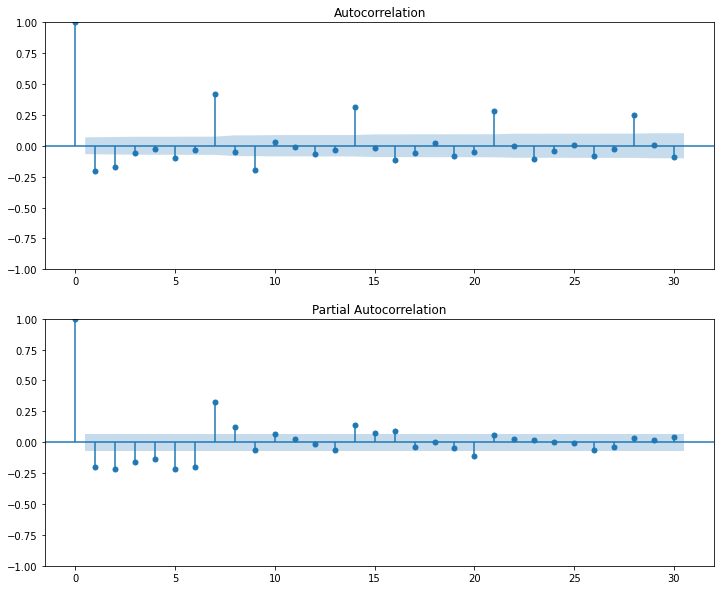

In [80]:
FIG_SIZE = (12, 10)

fig, ax = plt.subplots(2, 1, figsize=FIG_SIZE)
plot_acf(ts_transit[f"{d}-lag"].dropna(), ax=ax[0], lags=30)
plot_pacf(ts_transit[f"{d}-lag"].dropna(), ax=ax[1], lags=30, method="ols")
plt.show()


### Building the SARIMA Model


#### Grid Search for optimal parameters


In [81]:
train_data = ts_transit[f"{d}-lag"].loc[:"2021-11-30"]
test_data = ts_transit[f"{d}-lag"].loc["2021-12-01":"2022-03-01"]


#### Training the optimal SARIMA Model


In [82]:
best_model = SARIMAX(train_data, order=(1, 1, 3), seasonal_order=(1, 1, 3, 7)).fit(
    disp=False
)
print(best_model.summary())


                                     SARIMAX Results                                     
Dep. Variable:                             1-lag   No. Observations:                  655
Model:             SARIMAX(1, 1, 3)x(1, 1, 3, 7)   Log Likelihood               -1040.103
Date:                           Sat, 11 Jun 2022   AIC                           2098.206
Time:                                   12:23:27   BIC                           2138.457
Sample:                               02-15-2020   HQIC                          2113.822
                                    - 11-30-2021                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9879      0.018    -53.630      0.000      -1.024      -0.952
ma.L1         -0.3522      0.199     -1.770

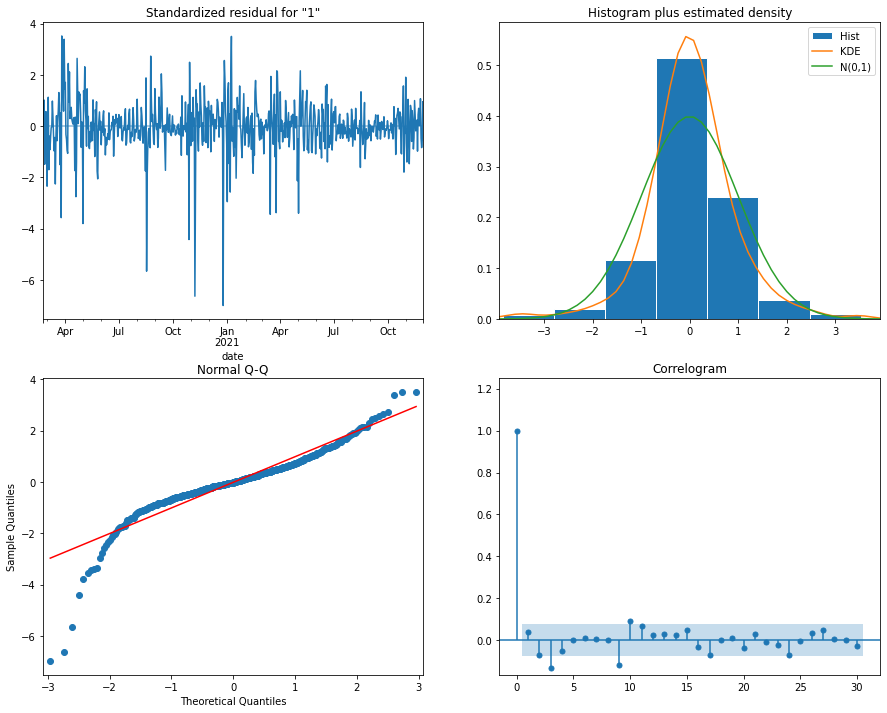

In [83]:
best_model.plot_diagnostics(lags=30, figsize=(15, 12), auto_ylims=True)
plt.show()


In [84]:
predictions, mape_list, forecast_ci = helper.walk_forward_validation(
    ts_transit, f"{d}-lag", train_data.shape[0], test_data.shape[0]
)


Optimization terminated successfully.
         Current function value: 1.589862
         Iterations: 3
         Function evaluations: 354
Optimization terminated successfully.
         Current function value: 1.589862
         Iterations: 3
         Function evaluations: 354
Optimization terminated successfully.
         Current function value: 1.585837
         Iterations: 3
         Function evaluations: 352
Optimization terminated successfully.
         Current function value: 1.584493
         Iterations: 3
         Function evaluations: 352
Optimization terminated successfully.
         Current function value: 1.580859
         Iterations: 3
         Function evaluations: 351
Optimization terminated successfully.
         Current function value: 1.602525
         Iterations: 3
         Function evaluations: 362
Optimization terminated successfully.
         Current function value: 1.604528
         Iterations: 3
         Function evaluations: 371
Optimization terminated successful

In [85]:
fig = go.Figure()

for x_data, y_data, name, opacity, in zip(
    [train_data.index.values, test_data.index.values, test_data.index.values],
    [train_data, test_data, predictions],
    ["train_data", "test_data", "predictions"],
    [1, 0.7, 0.7],
):
    fig.add_trace(
        go.Scatter(x=x_data, y=y_data, mode="lines", name=name, opacity=opacity)
    )

fig.update_layout(
    title=f"Forecast until {str(test_data.index[-1].date())}",
    width=PLOT_WIDTH,
    height=PLOT_HEIGHT,
    yaxis_ticksuffix="%",
)
fig.show()
fig.write_image(f"../plots/Forecast until {str(test_data.index[-1].date())}.png")


# Compare behavior between first and second wave period of the pandemic


In [86]:
covid.iloc[:, 1:] = covid.iloc[:, 1:].diff().astype(pd.Int64Dtype())
# First confirmed case was on 2020-02-26 (at index 35)
covid = covid.loc[35:, :]


In [87]:
fmt = "%Y-%m-%d"  # Specifying the date format

# First Wave
start_date = datetime.datetime.strptime("2020-02-16", fmt)
end_date = datetime.datetime.strptime("2020-07-10", fmt)

mask = (google["date"] >= start_date) & (google["date"] <= end_date)
fw_mobility = google.loc[mask].reset_index(drop=True)
mask = (covid["date"] >= start_date) & (covid["date"] <= end_date)
fw_cases = covid.loc[mask]

# Second Wave
start_date = datetime.datetime.strptime("2020-11-07", fmt)
end_date = datetime.datetime.strptime("2021-03-22", fmt)

mask = (google["date"] >= start_date) & (google["date"] <= end_date)
sw_mobility = google.loc[mask].reset_index(drop=True)
mask = (covid["date"] >= start_date) & (covid["date"] <= end_date)
sw_cases = covid.loc[mask]


## Distributions during each wave


In [88]:
fig = make_subplots(
    rows=2,
    cols=2,
    horizontal_spacing=0.03,
    vertical_spacing=0.05,
    shared_yaxes=True,
    subplot_titles=helper.TITLES[:4],
    x_title="Change (%)",
    y_title="Frequency (%)",
)
show = True

for col, position in zip(fw_mobility.columns[1:5], [(1, 1), (1, 2), (2, 1), (2, 2)]):
    for df, name, color_id in zip(
        [fw_mobility, sw_mobility], ["first wave", "second wave"], [0, 3]
    ):
        fig.add_trace(
            go.Histogram(
                x=df[col],
                nbinsx=30,
                name=name,
                marker_color=DEFAULT_PLOTLY_COLORS[color_id],
                showlegend=True if show else False,
            ),
            row=position[0],
            col=position[1],
        )
    show = False


fig.update_layout(
    title_text="Mobility Changes between first and second wave",
    title_x=0.5,
    bargap=0.2,  # gap between bars of adjacent location coordinates
    bargroupgap=0.1,  # gap between bars of the same location coordinates
    font_size=TITLE_FONT_SIZE,
    width=PLOT_WIDTH * 1.3,
    height=PLOT_HEIGHT * 2,
    xaxis=dict(rangeselector_font_size=AXIS_FONT_SIZE),
    yaxis=dict(tickfont_size=AXIS_FONT_SIZE),
)
fig.update_annotations(font_size=16)
fig.show()
fig.write_image("../plots/First vs Second Wave.png")


In [89]:
print(fw_cases["confirmed"].sum(), sw_cases["confirmed"].sum())


3732 186576
